# Assignement E04 - DSIM

*Marco Donzella*

Implement a script for image stitching of two images, following the guidelines shown during the laboratory.

Rules:

1. Use a pair of custom images (different from the ones provided).
2. If you don't have access to the SIFT function, it is possible to adopt an open source alternative such as ORB (https://docs.opencv.org/3.4.2/d1/d89/tutorial_py_orb.html).
3. It is not allowed to use cv.createStitcher() or other complete functions for image stitching.
4. You should, however, use pre-made functions for the computation of the Homography and for image warping.

Submission:

1. Notebook with well-commented steps and observations on the results.
2. If you submit a .py script instead of a notebook, attach a short report for the observations on the results.
3. Name the submitted file as: E04_surname_name_studentID

## Photo stitching - default images

N.B.: per poter utilizzare l'algoritmo *sift* occorre lavorare con la versione 3.4.2 di OpenCV. Occorre, dunque, verificare di avere installata la seguente versione.

In [ ]:
#!pip install opencv_contrib_python==3.4.2.17 --force-reinstall # installiamo l'ultima versione di cv contenente sift

In [ ]:
import cv2 as cv
print(cv.__version__)

3.4.2


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [15, 5] # width, height

Vengono caricate le due immagini di default su cui voler lavorare:

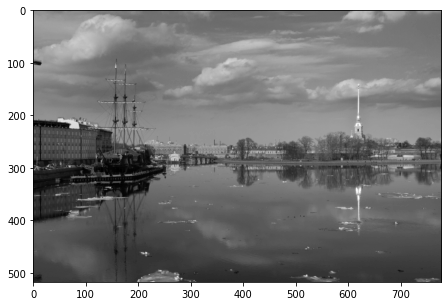

In [ ]:
boat1 = cv.imread('./boat1.jpg', 0)
plt.imshow(boat1, cmap='gray')

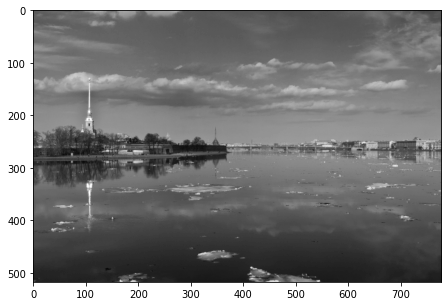

In [ ]:
boat3 = cv.imread('./boat3.jpg', 0)
plt.imshow(boat3, cmap='gray')

Successivamente vengono estratti i punti chiave delle due immagini e vengono determinati i vari matching.

In [ ]:
# Keypoint extraction
sift = cv.xfeatures2d.SIFT_create()
kps1, features1 = sift.detectAndCompute(boat1, None)
kps2, features2 = sift.detectAndCompute(boat3, None)
# Features matching
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [ ]:
print(len(kps1),len(kps2), len(matches)) 

1193 850 535


Per la prima immagine sono stati rilevati 1193 punti chiave, mentre per la seconda 850.

I matches, tuttavia, risultano essere 535 (quindi alcuni punti sono stati esclusi).

## 1. Find the homography which describes the transformation from the second set of points to the first one

In seguito viene definita la funzione *myHomography* che, prendendo in input le variabili *kps1*, *kps2* e *matches* create precedentemente, restituisce la matrice di Omografia H, di dimensione 3x3:

In [ ]:
def myHomography(kps1, kps2, matches):
  tp = []
  qp = []
  for m in matches:
    tp.append(kps2[m.trainIdx].pt)
    qp.append(kps1[m.queryIdx].pt)
  tp, qp = np.float32((tp, qp)) # formato necessario per usare la funzione cv.findHomography
  H, mask = cv.findHomography(tp, qp, cv.RANSAC) # metodo RANSAC
  return H

In [ ]:
H = myHomography(kps1, kps2, matches)
print(H)

[[ 5.70083154e-01 -2.20799284e-02  5.21896657e+02]
 [-1.51066884e-01  9.11596153e-01  3.06053901e+01]
 [-5.44265695e-04 -3.47411518e-05  1.00000000e+00]]


## 2. Apply the homography to the second image

In seguito viene definita la funzione *MyWarp* che, prendendo in input la seconda immagine (da voler collegare alla prima) e la matrice H definita precedentemente, restituisce la seconda immagine posizionata in uno spazio più grande ed inclinata, così da permettere il futuro posizionamento della prima:

In [ ]:
def MyWarp(im, H):  
  temp = cv.warpPerspective(im, H, (1180, 518)) # dimensioni fissate manualmente
  return temp

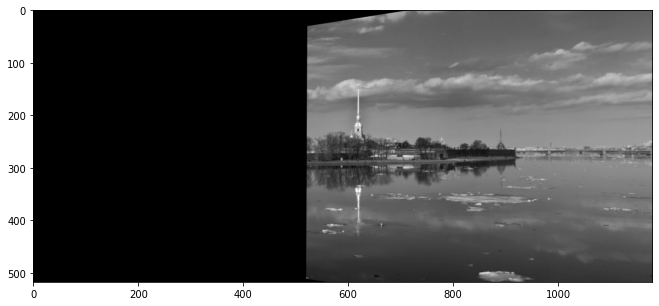

In [ ]:
# Apply a perspective warp to stitch the images together
temp = MyWarp(boat3, H)
plt.imshow(temp, cmap='gray'); plt.show()

## 3. Integrate the first image

In seguito viene definita la funzione *myCollage*, che prendendo in input la prima immagine e la parte non in comune della seconda, le unisce, creando un'unica immagine di dimensione maggiore:

In [ ]:
im_new = temp[0:518,780:1180] # solo la parte non in comune delle due immagini

In [ ]:
def myCollage(boat1, im_new):
  result = np.concatenate((boat1, im_new), axis=1)
  return result

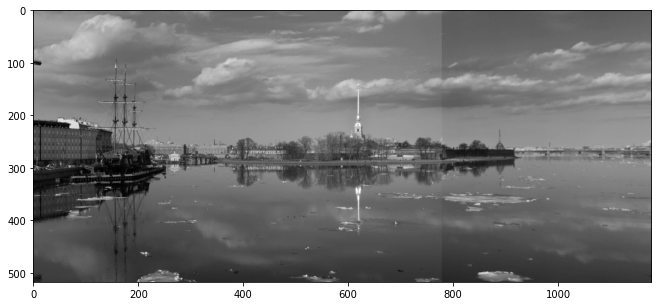

In [ ]:
result = myCollage(boat1, im_new)
plt.imshow(result, cmap='gray'); plt.show()

## Photo stitching - custom images

Ora verranno eseguiti gli stessi passaggi visti e descritti in precedenza, utilizzando, però, due immagini diverse.

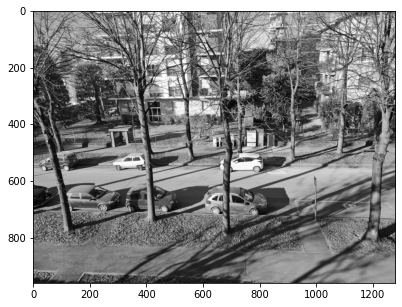

In [ ]:
im1 = cv.imread('./im1.jpg', 0)
plt.imshow(im1, cmap='gray')

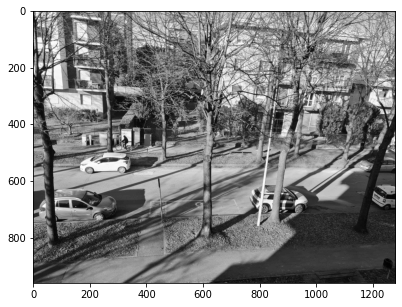

In [ ]:
im2 = cv.imread('./im2.jpg', 0)
plt.imshow(im2, cmap='gray')

In [ ]:
print(im1.shape, im2.shape) # check delle dimensioni delle nuove immagini

(960, 1280) (960, 1280)


In [ ]:
# Keypoint extraction
sift = cv.xfeatures2d.SIFT_create()
kps1, features1 = sift.detectAndCompute(im1, None)
kps2, features2 = sift.detectAndCompute(im2, None)
# Features matching
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [ ]:
print(len(kps1),len(kps2), len(matches)) 

15065 14480 8232


In questo caso sono stati molti più key-points nelle due immagini e, di conseguenza, molti più match. Per evitare di usarli tutti nelle successive analisi (dato che molti saranno match sbagliati), si decide di ordinarli in base alla distanza e di considerare solo i 4000 (50% circa) migliori.

In [ ]:
matches = sorted(matches, key = lambda x:x.distance) # ordiniamo i matches

In [ ]:
H = myHomography(kps1, kps2, matches[0:4000])
print(H)

[[ 5.58480084e-01  4.16866797e-01  3.24173662e+02]
 [-2.13324230e-01  9.52251978e-01  4.46554076e+01]
 [-3.73588911e-04  7.62300512e-05  1.00000000e+00]]


Viene definita una nuova funzione *MyWarp2* con dimensioni diverse rispetto a prima:

In [ ]:
def MyWarp2(im, H):  
  temp = cv.warpPerspective(im, H, (2200, 960)) # dimensioni fissate manualmente
  return temp

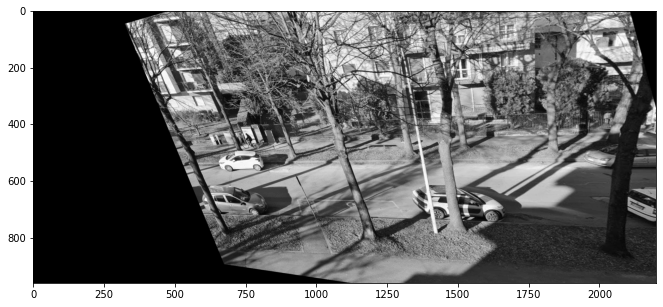

In [ ]:
temp = MyWarp2(im2, H)
plt.imshow(temp, cmap='gray'); plt.show()

In [ ]:
im_new_2 = temp[0:960,1300:2200] # solo la parte non in comune delle due immagini

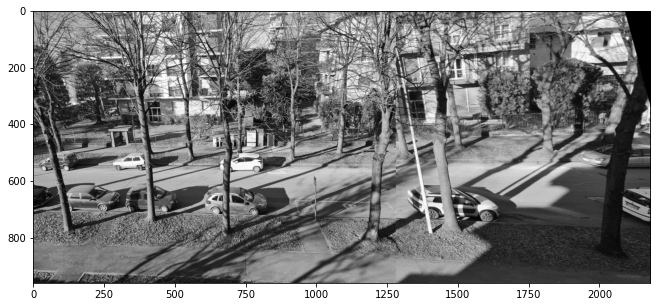

In [ ]:
result = myCollage(im1, im_new_2)
plt.imshow(result, cmap='gray'); plt.show()

## Curiosità - Procedimento con funzione già esistente 'createStitcher()'

Per curiosità viene eseguito il procedimento di stitching eseguito con le prime due immagini, utilizzando la funzione già disponibile in OpenCV. In questo caso il metodo verrà eseguito con le immagini a colori.

In [ ]:
dim=(1024,768) # fissare dimensione desiderata
left=cv.imread('./boat1.jpg', cv.IMREAD_COLOR)
left=cv.resize(left,dim,interpolation = cv.INTER_AREA)   #ReSize to (1024,768)
right=cv.imread('./boat3.jpg', cv.IMREAD_COLOR)
right=cv.resize(right,dim,interpolation = cv.INTER_AREA) #ReSize to (1024,768)

images=[]
images.append(left)
images.append(right)

In [ ]:
from google.colab.patches import cv2_imshow # perchè la funzione cv.imshow() genera problemi su colab

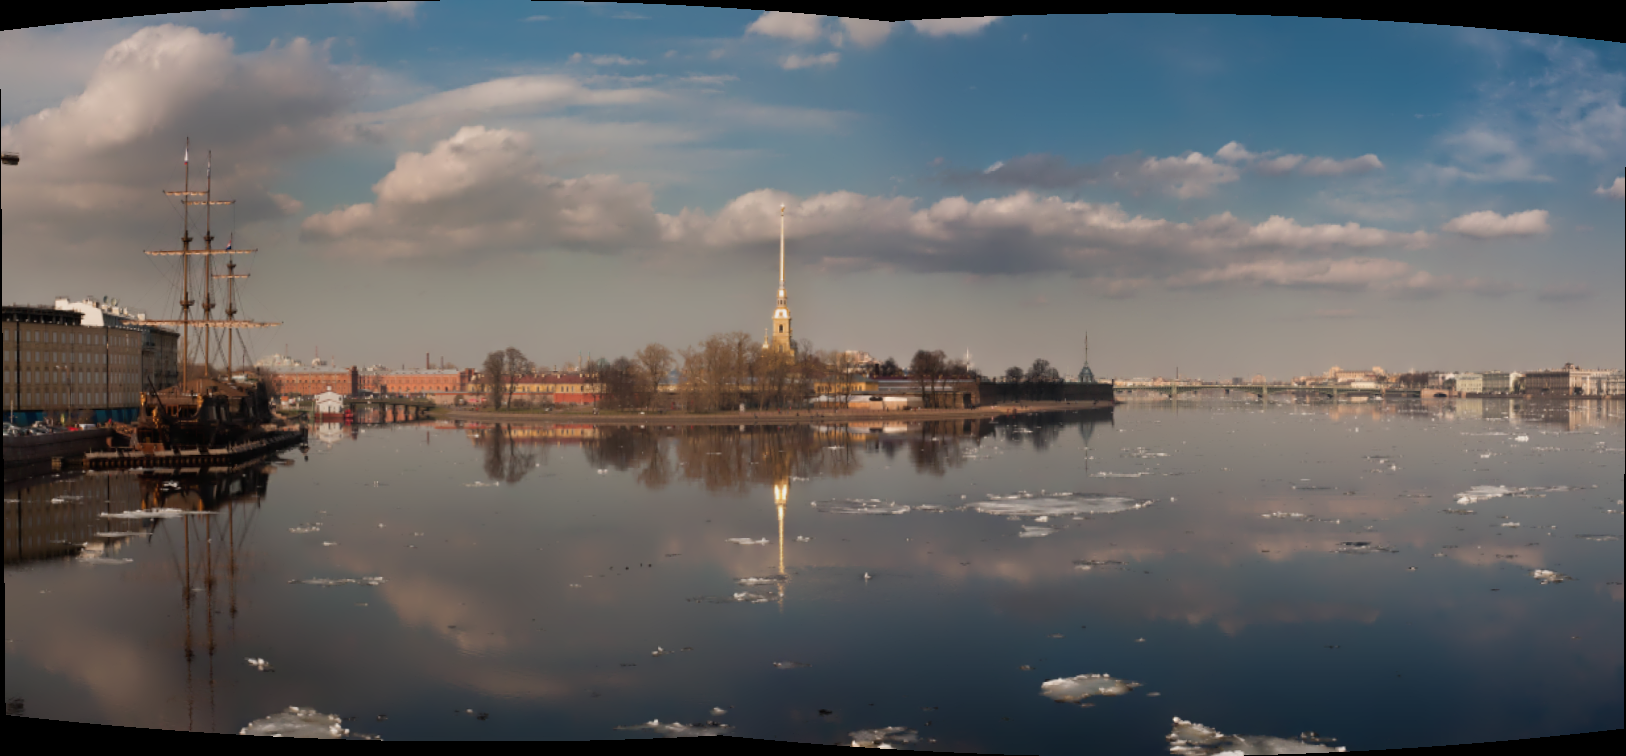

In [ ]:
stitcher = cv.createStitcher()
ret,pano = stitcher.stitch((images))

if ret==cv.STITCHER_OK:
    cv2_imshow(pano)
    cv.waitKey()
    cv.destroyAllWindows()
else:
    print("Error during Stitching")